In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
torch.manual_seed(1)
np.random.seed(0)

In [3]:
a = 32
b = 96
seq_len = 128
num = 1000

In [4]:
idxs = torch.randint(a, b, (num, ))

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal

In [6]:
size_ = 100

In [7]:
all_data = []
all_labels = []

for idx in tqdm(idxs):
    mu = torch.randint(3, 100, (1, size_), dtype=torch.float)
    
    m = MultivariateNormal(torch.ones(size_), torch.eye(size_))   
    x1 = []
    for _ in range(seq_len):
        x1_ = m.sample()
        x1.append(x1_) 
    x1 = torch.stack(x1)
    
    m = MultivariateNormal(mu[0], torch.eye(size_))   
    x2 = []
    for _ in range(seq_len):
        x2_ = m.sample()
        x2.append(x2_)      
    x2 = torch.stack(x2)  
    
    x = torch.cat([x1[:idx], x2[idx:]])
    label = torch.cat([torch.zeros(idx), torch.ones(seq_len-idx)])
    
    all_data.append(x)
    all_labels.append(label)

In [8]:
all_data = np.vstack(all_data)
all_labels = np.vstack(all_labels)

In [9]:
all_data.shape

(128000, 100)

In [10]:
all_data = all_data.reshape(num, seq_len, size_)

In [11]:
all_data.shape

(1000, 128, 100)

In [12]:
import os
SEQ_LEN = seq_len
IM_SIZE = size_

In [13]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.2, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

In [14]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(800, 128, 100)
(100, 128, 100)
(100, 128, 100)


In [15]:
!nvidia-smi

Thu May 27 11:50:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:03:00.0 Off |                  N/A |
| 66%   84C    P2   135W / 280W |  20728MiB / 24219MiB |     25%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   54C    P2    68W / 280W |  13733MiB / 24220MiB |     17%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0')

In [17]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [18]:
loss_delay_detection(torch.Tensor([0.9, 0.1, 0.3]), 3)

tensor(1.7570, device='cuda:0')

In [19]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 64
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss

In [21]:
# input data parameters
input_size = 100
output_size = SEQ_LEN
seq_len = SEQ_LEN

# model hyperparameters
hidden_dim = 8
n_layers = 2
num_workers = 1
learning_rate = 1e-3

batch_size = 16

In [22]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)

    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [23]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [24]:
def train_model(model, loss_function, epochs=100, print_every=30, LSTM_flag=False, RNN_flag=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            inputs, labels = inputs.to(device), labels.to(device)  

            if LSTM_flag:
                h = model.init_hidden(batch_size)
                h = tuple([e.data for e in h])
                output, h = model(inputs, h)
            elif RNN_flag:
                h = model.init_hidden(batch_size)
                h = torch.stack([e.data for e in h])
                h = torch.zeros(n_layers, batch_size, hidden_dim).to(device)
                output, h = model(inputs, h)                
            else:
                output = model(inputs)

            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    if LSTM_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = tuple([each.data for each in val_h])
                        val_out, val_h = model(val_inputs, val_h)
                    elif RNN_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = torch.stack([each.data for each in val_h])
                        val_h = torch.zeros(n_layers, batch_size, hidden_dim).to(device)
                        val_out, val_h = model(val_inputs, val_h)
                    else:
                        val_out = model(val_inputs)
                        
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

In [25]:
!rm -rf experiments5
!mkdir experiments5

### LSTM Model

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        #self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, 1)
        #self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        #self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        #out = self.dropout(out)
        #out = self.relu(out)
        #out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [27]:
model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
model_LSTM_custom.to(device)

LSTM(
  (lstm): LSTM(100, 8, num_layers=2, batch_first=True, dropout=0.5)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [28]:
model_LSTM_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 25, 5, LSTM_flag=True)

model_LSTM_custom = model_LSTM_custom.eval() 
torch.save(model_LSTM_custom, "experiments5/model_LSTM_custom.pth")

Epoch: 1/25... Step: 5... Loss: -0.604407... Val Loss: -0.605668
Epoch: 1/25... Step: 10... Loss: -0.637756... Val Loss: -0.502718
Epoch: 1/25... Step: 15... Loss: -0.671414... Val Loss: -0.631190
Epoch: 1/25... Step: 20... Loss: -0.451272... Val Loss: -0.649175
Epoch: 1/25... Step: 25... Loss: -0.553736... Val Loss: -0.632505
Epoch: 1/25... Step: 30... Loss: -0.508770... Val Loss: -0.545099
Epoch: 1/25... Step: 35... Loss: -0.704047... Val Loss: -0.604230
Epoch: 1/25... Step: 40... Loss: -0.581641... Val Loss: -0.597096
Epoch: 1/25... Step: 45... Loss: -0.563901... Val Loss: -0.650569
Epoch: 1/25... Step: 50... Loss: -0.720517... Val Loss: -0.611521
Epoch: 2/25... Step: 55... Loss: -0.942636... Val Loss: -0.582507
Epoch: 2/25... Step: 60... Loss: -0.863714... Val Loss: -0.635630
Epoch: 2/25... Step: 65... Loss: -0.687018... Val Loss: -0.906665
Epoch: 2/25... Step: 70... Loss: -0.905866... Val Loss: -0.845352
Epoch: 2/25... Step: 75... Loss: -0.878044... Val Loss: -0.785459
Epoch: 2/25

Epoch: 13/25... Step: 620... Loss: -6.695692... Val Loss: -8.965834
Epoch: 13/25... Step: 625... Loss: -5.965727... Val Loss: -8.967962
Epoch: 13/25... Step: 630... Loss: -6.724343... Val Loss: -9.002606
Epoch: 13/25... Step: 635... Loss: -6.591005... Val Loss: -8.853921
Epoch: 13/25... Step: 640... Loss: -7.766271... Val Loss: -8.606789
Epoch: 13/25... Step: 645... Loss: -9.157413... Val Loss: -9.294240
Epoch: 13/25... Step: 650... Loss: -8.569445... Val Loss: -9.564612
Epoch: 14/25... Step: 655... Loss: -8.895295... Val Loss: -8.898422
Epoch: 14/25... Step: 660... Loss: -8.476484... Val Loss: -8.956016
Epoch: 14/25... Step: 665... Loss: -7.313353... Val Loss: -9.116893
Epoch: 14/25... Step: 670... Loss: -7.785528... Val Loss: -9.439328
Epoch: 14/25... Step: 675... Loss: -8.601885... Val Loss: -9.570348
Epoch: 14/25... Step: 680... Loss: -10.206529... Val Loss: -9.593722
Epoch: 14/25... Step: 685... Loss: -8.821957... Val Loss: -9.197196
Epoch: 14/25... Step: 690... Loss: -6.346632...

Epoch: 25/25... Step: 1220... Loss: -10.597251... Val Loss: -10.484030
Epoch: 25/25... Step: 1225... Loss: -12.363069... Val Loss: -9.797566
Epoch: 25/25... Step: 1230... Loss: -8.835525... Val Loss: -10.070121
Epoch: 25/25... Step: 1235... Loss: -7.314817... Val Loss: -10.193811
Epoch: 25/25... Step: 1240... Loss: -8.991651... Val Loss: -9.886011
Epoch: 25/25... Step: 1245... Loss: -12.444195... Val Loss: -9.711245
Epoch: 25/25... Step: 1250... Loss: -7.227942... Val Loss: -10.385242


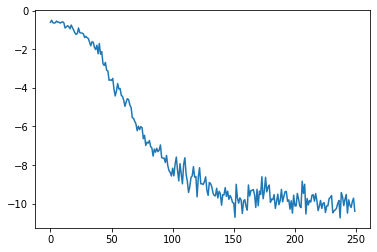

In [29]:
plt.plot(overall_val_loss_list)

In [30]:
model_LSTM_bce = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
model_LSTM_bce.to(device)

LSTM(
  (lstm): LSTM(100, 8, num_layers=2, batch_first=True, dropout=0.5)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [31]:
model_LSTM_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_LSTM_bce, bce_loss_function, 
                                                                                       25, 5, LSTM_flag=True)
model_LSTM_bce = model_LSTM_bce.eval()
torch.save(model_LSTM_bce, "experiments5/model_LSTM_bce.pth")

Epoch: 1/25... Step: 5... Loss: 0.700949... Val Loss: 0.697701
Epoch: 1/25... Step: 10... Loss: 0.691598... Val Loss: 0.692064
Epoch: 1/25... Step: 15... Loss: 0.685382... Val Loss: 0.687820
Epoch: 1/25... Step: 20... Loss: 0.685417... Val Loss: 0.684934
Epoch: 1/25... Step: 25... Loss: 0.692216... Val Loss: 0.682874
Epoch: 1/25... Step: 30... Loss: 0.679019... Val Loss: 0.679378
Epoch: 1/25... Step: 35... Loss: 0.680871... Val Loss: 0.674984
Epoch: 1/25... Step: 40... Loss: 0.685123... Val Loss: 0.671303
Epoch: 1/25... Step: 45... Loss: 0.674628... Val Loss: 0.665717
Epoch: 1/25... Step: 50... Loss: 0.663530... Val Loss: 0.660816
Epoch: 2/25... Step: 55... Loss: 0.659427... Val Loss: 0.654617
Epoch: 2/25... Step: 60... Loss: 0.658080... Val Loss: 0.647458
Epoch: 2/25... Step: 65... Loss: 0.642035... Val Loss: 0.639370
Epoch: 2/25... Step: 70... Loss: 0.631664... Val Loss: 0.626312
Epoch: 2/25... Step: 75... Loss: 0.612685... Val Loss: 0.614171
Epoch: 2/25... Step: 80... Loss: 0.591957

Epoch: 13/25... Step: 635... Loss: 0.044838... Val Loss: 0.039476
Epoch: 13/25... Step: 640... Loss: 0.058200... Val Loss: 0.039063
Epoch: 13/25... Step: 645... Loss: 0.048068... Val Loss: 0.041520
Epoch: 13/25... Step: 650... Loss: 0.046898... Val Loss: 0.038021
Epoch: 14/25... Step: 655... Loss: 0.048289... Val Loss: 0.037206
Epoch: 14/25... Step: 660... Loss: 0.045860... Val Loss: 0.036679
Epoch: 14/25... Step: 665... Loss: 0.048316... Val Loss: 0.035848
Epoch: 14/25... Step: 670... Loss: 0.048598... Val Loss: 0.035361
Epoch: 14/25... Step: 675... Loss: 0.043820... Val Loss: 0.034752
Epoch: 14/25... Step: 680... Loss: 0.044198... Val Loss: 0.034339
Epoch: 14/25... Step: 685... Loss: 0.039437... Val Loss: 0.034082
Epoch: 14/25... Step: 690... Loss: 0.041256... Val Loss: 0.033346
Epoch: 14/25... Step: 695... Loss: 0.045349... Val Loss: 0.033499
Epoch: 14/25... Step: 700... Loss: 0.042251... Val Loss: 0.033567
Epoch: 15/25... Step: 705... Loss: 0.043104... Val Loss: 0.033174
Epoch: 15/

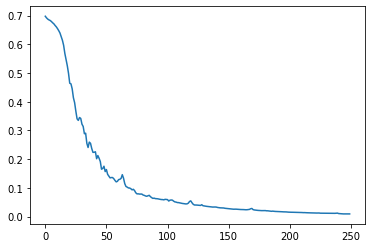

In [32]:
plt.plot(bce_overall_val_loss_list)

In [33]:
model_LSTM_combined = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_LSTM_combined.to(device)

LSTM(
  (lstm): LSTM(100, 8, num_layers=2, batch_first=True, dropout=0.5)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [34]:
model_LSTM_combined, _ = train_model(model_LSTM_combined, first_bce_loss_function, 25, 5, 
                                    LSTM_flag=True)

model_LSTM_combined, _ = train_model(model_LSTM_combined, second_custom_loss_function, 25, 5, 
                                    LSTM_flag=True)


model_LSTM_combined = model_LSTM_combined.eval()
torch.save(model_LSTM_combined, "experiments5/model_LSTM_combined.pth")

Epoch: 1/25... Step: 5... Loss: 0.688463... Val Loss: 0.691186
Epoch: 1/25... Step: 10... Loss: 0.688647... Val Loss: 0.688304
Epoch: 1/25... Step: 15... Loss: 0.683906... Val Loss: 0.685252
Epoch: 1/25... Step: 20... Loss: 0.678499... Val Loss: 0.681352
Epoch: 1/25... Step: 25... Loss: 0.678417... Val Loss: 0.677400
Epoch: 1/25... Step: 30... Loss: 0.664716... Val Loss: 0.669988
Epoch: 1/25... Step: 35... Loss: 0.660628... Val Loss: 0.663929
Epoch: 1/25... Step: 40... Loss: 0.648433... Val Loss: 0.658714
Epoch: 1/25... Step: 45... Loss: 0.652225... Val Loss: 0.654924
Epoch: 1/25... Step: 50... Loss: 0.647876... Val Loss: 0.638568
Epoch: 2/25... Step: 55... Loss: 0.632015... Val Loss: 0.621824
Epoch: 2/25... Step: 60... Loss: 0.622972... Val Loss: 0.603928
Epoch: 2/25... Step: 65... Loss: 0.602635... Val Loss: 0.593697
Epoch: 2/25... Step: 70... Loss: 0.571832... Val Loss: 0.580376
Epoch: 2/25... Step: 75... Loss: 0.572482... Val Loss: 0.561894
Epoch: 2/25... Step: 80... Loss: 0.532821

Epoch: 13/25... Step: 635... Loss: 0.046826... Val Loss: 0.046013
Epoch: 13/25... Step: 640... Loss: 0.054125... Val Loss: 0.041678
Epoch: 13/25... Step: 645... Loss: 0.059298... Val Loss: 0.039950
Epoch: 13/25... Step: 650... Loss: 0.057987... Val Loss: 0.039216
Epoch: 14/25... Step: 655... Loss: 0.052489... Val Loss: 0.039101
Epoch: 14/25... Step: 660... Loss: 0.050071... Val Loss: 0.038729
Epoch: 14/25... Step: 665... Loss: 0.039350... Val Loss: 0.038998
Epoch: 14/25... Step: 670... Loss: 0.045953... Val Loss: 0.039320
Epoch: 14/25... Step: 675... Loss: 0.047165... Val Loss: 0.039483
Epoch: 14/25... Step: 680... Loss: 0.043577... Val Loss: 0.039306
Epoch: 14/25... Step: 685... Loss: 0.045988... Val Loss: 0.038422
Epoch: 14/25... Step: 690... Loss: 0.046444... Val Loss: 0.038783
Epoch: 14/25... Step: 695... Loss: 0.043604... Val Loss: 0.038444
Epoch: 14/25... Step: 700... Loss: 0.052524... Val Loss: 0.036859
Epoch: 15/25... Step: 705... Loss: 0.037575... Val Loss: 0.036100
Epoch: 15/

Epoch: 1/25... Step: 5... Loss: -3.603371... Val Loss: -0.677871
Epoch: 1/25... Step: 10... Loss: -4.531753... Val Loss: -2.876773
Epoch: 1/25... Step: 15... Loss: -5.915418... Val Loss: -4.746132
Epoch: 1/25... Step: 20... Loss: -5.853433... Val Loss: -4.853887
Epoch: 1/25... Step: 25... Loss: -5.518601... Val Loss: -3.998133
Epoch: 1/25... Step: 30... Loss: -5.442787... Val Loss: -4.273592
Epoch: 1/25... Step: 35... Loss: -7.090057... Val Loss: -3.861968
Epoch: 1/25... Step: 40... Loss: -6.410924... Val Loss: -4.110089
Epoch: 1/25... Step: 45... Loss: -8.051462... Val Loss: -4.674301
Epoch: 1/25... Step: 50... Loss: -7.152866... Val Loss: -5.603784
Epoch: 2/25... Step: 55... Loss: -4.777099... Val Loss: -5.149696
Epoch: 2/25... Step: 60... Loss: -7.462238... Val Loss: -5.208692
Epoch: 2/25... Step: 65... Loss: -7.140537... Val Loss: -4.245968
Epoch: 2/25... Step: 70... Loss: -7.590719... Val Loss: -3.444130
Epoch: 2/25... Step: 75... Loss: -5.897545... Val Loss: -4.335581
Epoch: 2/25

Epoch: 13/25... Step: 615... Loss: -9.951107... Val Loss: -9.859679
Epoch: 13/25... Step: 620... Loss: -9.416483... Val Loss: -9.265901
Epoch: 13/25... Step: 625... Loss: -11.415397... Val Loss: -8.986481
Epoch: 13/25... Step: 630... Loss: -8.787250... Val Loss: -8.701890
Epoch: 13/25... Step: 635... Loss: -7.809468... Val Loss: -9.528173
Epoch: 13/25... Step: 640... Loss: -9.811647... Val Loss: -9.888105
Epoch: 13/25... Step: 645... Loss: -7.353311... Val Loss: -9.589846
Epoch: 13/25... Step: 650... Loss: -9.479480... Val Loss: -9.903983
Epoch: 14/25... Step: 655... Loss: -7.806689... Val Loss: -9.585794
Epoch: 14/25... Step: 660... Loss: -7.942526... Val Loss: -11.077496
Epoch: 14/25... Step: 665... Loss: -7.554070... Val Loss: -10.792216
Epoch: 14/25... Step: 670... Loss: -9.789824... Val Loss: -9.997577
Epoch: 14/25... Step: 675... Loss: -9.647913... Val Loss: -10.252087
Epoch: 14/25... Step: 680... Loss: -10.082825... Val Loss: -10.246220
Epoch: 14/25... Step: 685... Loss: -8.8193

Epoch: 25/25... Step: 1210... Loss: -8.946107... Val Loss: -10.249153
Epoch: 25/25... Step: 1215... Loss: -10.496469... Val Loss: -10.107058
Epoch: 25/25... Step: 1220... Loss: -10.539537... Val Loss: -10.371026
Epoch: 25/25... Step: 1225... Loss: -6.557305... Val Loss: -9.790898
Epoch: 25/25... Step: 1230... Loss: -9.063004... Val Loss: -10.349907
Epoch: 25/25... Step: 1235... Loss: -8.335945... Val Loss: -9.563498
Epoch: 25/25... Step: 1240... Loss: -10.102111... Val Loss: -11.232192
Epoch: 25/25... Step: 1245... Loss: -9.283959... Val Loss: -10.347525
Epoch: 25/25... Step: 1250... Loss: -9.963631... Val Loss: -10.912159


### GRU

In [35]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(GRU, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.gru = nn.GRU(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        #self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, 1)
        #self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        #self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        gru_out, hidden = self.gru(input_seq, hidden)  
        gru_out = gru_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(gru_out)
        #out = self.dropout(out)
        #out = self.relu(out)
        #out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [36]:
model_GRU_custom = GRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
model_GRU_custom.to(device)

GRU(
  (gru): GRU(100, 8, num_layers=2, batch_first=True, dropout=0.5)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [37]:
model_GRU_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_GRU_custom, loss_function, 25, 5, RNN_flag=True)

model_GRU_custom = model_GRU_custom.eval()
torch.save(model_GRU_custom, "experiments5/model_GRU_custom.pth")

Epoch: 1/25... Step: 5... Loss: -0.703434... Val Loss: -0.652426
Epoch: 1/25... Step: 10... Loss: -0.584216... Val Loss: -0.782807
Epoch: 1/25... Step: 15... Loss: -0.821413... Val Loss: -0.771342
Epoch: 1/25... Step: 20... Loss: -0.868312... Val Loss: -0.947724
Epoch: 1/25... Step: 25... Loss: -1.176370... Val Loss: -1.124542
Epoch: 1/25... Step: 30... Loss: -0.503857... Val Loss: -0.954336
Epoch: 1/25... Step: 35... Loss: -1.215198... Val Loss: -1.062440
Epoch: 1/25... Step: 40... Loss: -1.084305... Val Loss: -0.926772
Epoch: 1/25... Step: 45... Loss: -1.327196... Val Loss: -1.105601
Epoch: 1/25... Step: 50... Loss: -0.597521... Val Loss: -1.125088
Epoch: 2/25... Step: 55... Loss: -1.183529... Val Loss: -0.907906
Epoch: 2/25... Step: 60... Loss: -0.812318... Val Loss: -1.425794
Epoch: 2/25... Step: 65... Loss: -1.115536... Val Loss: -1.299913
Epoch: 2/25... Step: 70... Loss: -1.283189... Val Loss: -1.486270
Epoch: 2/25... Step: 75... Loss: -1.562299... Val Loss: -1.334688
Epoch: 2/25

Epoch: 13/25... Step: 615... Loss: -7.529008... Val Loss: -10.410497
Epoch: 13/25... Step: 620... Loss: -9.666595... Val Loss: -9.929573
Epoch: 13/25... Step: 625... Loss: -6.816884... Val Loss: -10.404114
Epoch: 13/25... Step: 630... Loss: -7.112477... Val Loss: -10.141775
Epoch: 13/25... Step: 635... Loss: -7.381912... Val Loss: -10.228631
Epoch: 13/25... Step: 640... Loss: -8.864421... Val Loss: -9.949001
Epoch: 13/25... Step: 645... Loss: -9.319788... Val Loss: -10.336550
Epoch: 13/25... Step: 650... Loss: -10.270136... Val Loss: -10.201519
Epoch: 14/25... Step: 655... Loss: -10.226048... Val Loss: -10.359843
Epoch: 14/25... Step: 660... Loss: -10.283031... Val Loss: -10.375340
Epoch: 14/25... Step: 665... Loss: -10.633044... Val Loss: -9.454796
Epoch: 14/25... Step: 670... Loss: -6.277083... Val Loss: -9.365841
Epoch: 14/25... Step: 675... Loss: -11.646494... Val Loss: -9.653968
Epoch: 14/25... Step: 680... Loss: -10.996373... Val Loss: -9.579776
Epoch: 14/25... Step: 685... Loss:

Epoch: 25/25... Step: 1210... Loss: -11.943107... Val Loss: -10.239705
Epoch: 25/25... Step: 1215... Loss: -9.375229... Val Loss: -10.040753
Epoch: 25/25... Step: 1220... Loss: -10.351520... Val Loss: -10.887430
Epoch: 25/25... Step: 1225... Loss: -9.262682... Val Loss: -9.763786
Epoch: 25/25... Step: 1230... Loss: -9.596099... Val Loss: -11.357996
Epoch: 25/25... Step: 1235... Loss: -11.446928... Val Loss: -11.168875
Epoch: 25/25... Step: 1240... Loss: -8.574115... Val Loss: -10.994047
Epoch: 25/25... Step: 1245... Loss: -10.600233... Val Loss: -10.082887
Epoch: 25/25... Step: 1250... Loss: -9.957615... Val Loss: -11.686375


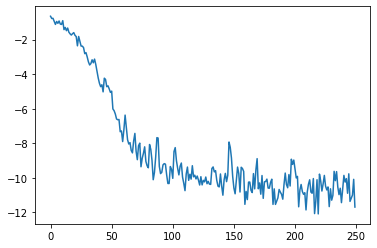

In [38]:
plt.plot(overall_val_loss_list)

In [39]:
model_GRU_bce = GRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
model_GRU_bce.to(device)

GRU(
  (gru): GRU(100, 8, num_layers=2, batch_first=True, dropout=0.5)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [40]:
model_GRU_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_GRU_bce, bce_loss_function, 
                                                                                       25, 5, RNN_flag=True)

model_GRU_bce = model_GRU_bce.eval()
torch.save(model_GRU_bce, "experiments5/model_GRU_bce.pth")

Epoch: 1/25... Step: 5... Loss: 0.704066... Val Loss: 0.698853
Epoch: 1/25... Step: 10... Loss: 0.697768... Val Loss: 0.694935
Epoch: 1/25... Step: 15... Loss: 0.698220... Val Loss: 0.691358
Epoch: 1/25... Step: 20... Loss: 0.701229... Val Loss: 0.688769
Epoch: 1/25... Step: 25... Loss: 0.686553... Val Loss: 0.685964
Epoch: 1/25... Step: 30... Loss: 0.694018... Val Loss: 0.684159
Epoch: 1/25... Step: 35... Loss: 0.691526... Val Loss: 0.679620
Epoch: 1/25... Step: 40... Loss: 0.683222... Val Loss: 0.675182
Epoch: 1/25... Step: 45... Loss: 0.688039... Val Loss: 0.672379
Epoch: 1/25... Step: 50... Loss: 0.649033... Val Loss: 0.665630
Epoch: 2/25... Step: 55... Loss: 0.673889... Val Loss: 0.661628
Epoch: 2/25... Step: 60... Loss: 0.663014... Val Loss: 0.657672
Epoch: 2/25... Step: 65... Loss: 0.664524... Val Loss: 0.652672
Epoch: 2/25... Step: 70... Loss: 0.660021... Val Loss: 0.646479
Epoch: 2/25... Step: 75... Loss: 0.652597... Val Loss: 0.635949
Epoch: 2/25... Step: 80... Loss: 0.640079

Epoch: 13/25... Step: 635... Loss: 0.033584... Val Loss: 0.057478
Epoch: 13/25... Step: 640... Loss: 0.039303... Val Loss: 0.059405
Epoch: 13/25... Step: 645... Loss: 0.055445... Val Loss: 0.059658
Epoch: 13/25... Step: 650... Loss: 0.027945... Val Loss: 0.056932
Epoch: 14/25... Step: 655... Loss: 0.046921... Val Loss: 0.056942
Epoch: 14/25... Step: 660... Loss: 0.037491... Val Loss: 0.052784
Epoch: 14/25... Step: 665... Loss: 0.040920... Val Loss: 0.050780
Epoch: 14/25... Step: 670... Loss: 0.033892... Val Loss: 0.050214
Epoch: 14/25... Step: 675... Loss: 0.028422... Val Loss: 0.051769
Epoch: 14/25... Step: 680... Loss: 0.033290... Val Loss: 0.055809
Epoch: 14/25... Step: 685... Loss: 0.028611... Val Loss: 0.056526
Epoch: 14/25... Step: 690... Loss: 0.024437... Val Loss: 0.056202
Epoch: 14/25... Step: 695... Loss: 0.029830... Val Loss: 0.055607
Epoch: 14/25... Step: 700... Loss: 0.038328... Val Loss: 0.055546
Epoch: 15/25... Step: 705... Loss: 0.033595... Val Loss: 0.055625
Epoch: 15/

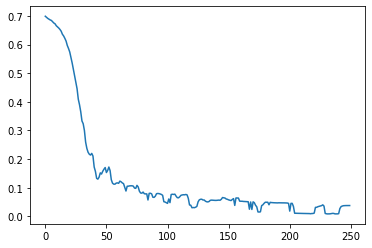

In [41]:
plt.plot(bce_overall_val_loss_list)

In [42]:
model_GRU_combined = GRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_GRU_combined.to(device)

GRU(
  (gru): GRU(100, 8, num_layers=2, batch_first=True, dropout=0.5)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [43]:
model_GRU_combined, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_GRU_combined, first_bce_loss_function, 25, 5, 
                                    RNN_flag=True)


model_GRU_combined, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_GRU_combined, second_custom_loss_function, 25, 5, 
                                    RNN_flag=True)

model_GRU_combined = model_GRU_combined.eval()
torch.save(model_GRU_combined, "experiments5/model_GRU_combined.pth")

Epoch: 1/25... Step: 5... Loss: 0.698638... Val Loss: 0.691034
Epoch: 1/25... Step: 10... Loss: 0.699350... Val Loss: 0.685303
Epoch: 1/25... Step: 15... Loss: 0.670620... Val Loss: 0.677503
Epoch: 1/25... Step: 20... Loss: 0.672803... Val Loss: 0.671388
Epoch: 1/25... Step: 25... Loss: 0.669042... Val Loss: 0.666557
Epoch: 1/25... Step: 30... Loss: 0.673758... Val Loss: 0.659999
Epoch: 1/25... Step: 35... Loss: 0.658289... Val Loss: 0.652261
Epoch: 1/25... Step: 40... Loss: 0.655914... Val Loss: 0.646705
Epoch: 1/25... Step: 45... Loss: 0.641595... Val Loss: 0.639332
Epoch: 1/25... Step: 50... Loss: 0.657239... Val Loss: 0.628439
Epoch: 2/25... Step: 55... Loss: 0.649843... Val Loss: 0.626342
Epoch: 2/25... Step: 60... Loss: 0.644356... Val Loss: 0.621409
Epoch: 2/25... Step: 65... Loss: 0.624703... Val Loss: 0.610199
Epoch: 2/25... Step: 70... Loss: 0.617166... Val Loss: 0.601494
Epoch: 2/25... Step: 75... Loss: 0.608926... Val Loss: 0.589767
Epoch: 2/25... Step: 80... Loss: 0.594854

Epoch: 13/25... Step: 635... Loss: 0.040010... Val Loss: 0.030827
Epoch: 13/25... Step: 640... Loss: 0.043490... Val Loss: 0.029931
Epoch: 13/25... Step: 645... Loss: 0.040500... Val Loss: 0.029340
Epoch: 13/25... Step: 650... Loss: 0.043990... Val Loss: 0.029238
Epoch: 14/25... Step: 655... Loss: 0.035075... Val Loss: 0.028923
Epoch: 14/25... Step: 660... Loss: 0.032585... Val Loss: 0.028547
Epoch: 14/25... Step: 665... Loss: 0.049164... Val Loss: 0.028783
Epoch: 14/25... Step: 670... Loss: 0.043067... Val Loss: 0.029483
Epoch: 14/25... Step: 675... Loss: 0.079897... Val Loss: 0.039269
Epoch: 14/25... Step: 680... Loss: 0.042898... Val Loss: 0.043078
Epoch: 14/25... Step: 685... Loss: 0.028428... Val Loss: 0.025614
Epoch: 14/25... Step: 690... Loss: 0.031422... Val Loss: 0.043820
Epoch: 14/25... Step: 695... Loss: 0.035810... Val Loss: 0.044080
Epoch: 14/25... Step: 700... Loss: 0.059177... Val Loss: 0.043742
Epoch: 15/25... Step: 705... Loss: 0.033177... Val Loss: 0.043559
Epoch: 15/

Epoch: 1/25... Step: 5... Loss: -1.415816... Val Loss: 1.096241
Epoch: 1/25... Step: 10... Loss: -3.169396... Val Loss: 0.964474
Epoch: 1/25... Step: 15... Loss: -2.726161... Val Loss: 0.130376
Epoch: 1/25... Step: 20... Loss: -4.289229... Val Loss: -1.175742
Epoch: 1/25... Step: 25... Loss: -3.844397... Val Loss: -1.111960
Epoch: 1/25... Step: 30... Loss: -5.644851... Val Loss: -1.046296
Epoch: 1/25... Step: 35... Loss: -4.040616... Val Loss: -0.707341
Epoch: 1/25... Step: 40... Loss: -4.440052... Val Loss: -0.975673
Epoch: 1/25... Step: 45... Loss: -3.749215... Val Loss: -1.409883
Epoch: 1/25... Step: 50... Loss: -5.470223... Val Loss: -1.327820
Epoch: 2/25... Step: 55... Loss: -5.000204... Val Loss: -1.373495
Epoch: 2/25... Step: 60... Loss: -5.253268... Val Loss: 1.862118
Epoch: 2/25... Step: 65... Loss: -4.643843... Val Loss: 2.089784
Epoch: 2/25... Step: 70... Loss: -4.877808... Val Loss: 1.475239
Epoch: 2/25... Step: 75... Loss: -5.571680... Val Loss: 1.784887
Epoch: 2/25... Ste

Epoch: 13/25... Step: 620... Loss: -10.942843... Val Loss: 2.427965
Epoch: 13/25... Step: 625... Loss: -11.143273... Val Loss: 2.921694
Epoch: 13/25... Step: 630... Loss: -10.894124... Val Loss: 2.127568
Epoch: 13/25... Step: 635... Loss: -8.736551... Val Loss: 1.899667
Epoch: 13/25... Step: 640... Loss: -10.417834... Val Loss: 0.028962
Epoch: 13/25... Step: 645... Loss: -9.507421... Val Loss: 0.131318
Epoch: 13/25... Step: 650... Loss: -7.556658... Val Loss: 1.237635
Epoch: 14/25... Step: 655... Loss: -8.219566... Val Loss: 2.559054
Epoch: 14/25... Step: 660... Loss: -8.936557... Val Loss: 2.386699
Epoch: 14/25... Step: 665... Loss: -5.967072... Val Loss: 1.775988
Epoch: 14/25... Step: 670... Loss: -9.618675... Val Loss: 1.169278
Epoch: 14/25... Step: 675... Loss: -9.292246... Val Loss: 0.247539
Epoch: 14/25... Step: 680... Loss: -8.090913... Val Loss: 0.360077
Epoch: 14/25... Step: 685... Loss: -9.794702... Val Loss: 0.870767
Epoch: 14/25... Step: 690... Loss: -8.294423... Val Loss: 

Epoch: 25/25... Step: 1230... Loss: -7.981751... Val Loss: 1.612333
Epoch: 25/25... Step: 1235... Loss: -7.069818... Val Loss: 1.443925
Epoch: 25/25... Step: 1240... Loss: -5.902755... Val Loss: 1.574079
Epoch: 25/25... Step: 1245... Loss: -9.091560... Val Loss: 1.490791
Epoch: 25/25... Step: 1250... Loss: -9.272941... Val Loss: 2.057549


# Calculate metrics for different models

In [48]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [49]:
test_batch_size = 16

In [50]:
def get_quality_metrics(test_loader, model, threshold=0.5, LSTM_flag=False, RNN_flag=False):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    model.eval()
    for test_inputs, test_true_labels in test_loader:
            
        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)

        if LSTM_flag:
            test_hidden = model.init_hidden(test_batch_size)
            test_hidden = tuple([each.data for each in test_hidden])
            test_predictions, test_hidden = model(test_inputs, test_hidden)
        elif RNN_flag:
            test_hidden = torch.zeros(n_layers, test_batch_size, hidden_dim).to(device)
            test_predictions, test_hidden = model(test_inputs, test_hidden)            
        else:
            test_predictions = model(test_inputs)
            
        test_loss = loss_function(test_predictions.squeeze(), test_true_labels.float())
        test_loss_list += [test_loss.cpu().clone().detach()]

        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [51]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list, LSTM_flag=False, RNN_flag=False):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold, LSTM_flag, RNN_flag)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        #print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

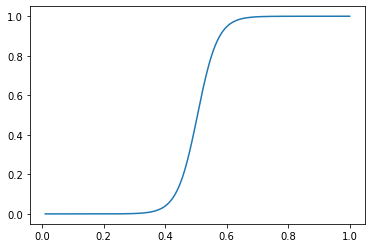

In [52]:
threshold_number = 200
threshold_list = np.linspace(-15, 15, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
plt.plot(np.linspace(0.01, 1, threshold_number), threshold_list)

In [53]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

In [54]:
batch, labels = next(iter(final_test_loader))
batch = batch.to(device)

In [55]:
hidden = model_LSTM_bce.init_hidden(4)
hidden = tuple([each.data for each in hidden])
pred = model_LSTM_bce(batch, hidden)

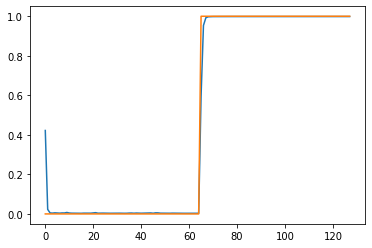

In [56]:
i = 2
plt.plot(pred[0][i].detach().cpu().numpy())
plt.plot(labels[i])

### Evaluate LSTM

In [57]:
#model_LSTM_bce = torch.load("experiments2/model_LSTM_bce.pth")
#model_LSTM_custom = torch.load("experiments2/model_LSTM_custom.pth")
#model_LSTM_combined = torch.load("experiments2/model_LSTM_combined.pth")

In [58]:
test_batch_size = 4
loss_function = CustomLoss()
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_bce, fn_number_list_LSTM_bce, 
 delay_list_LSTM_bce, fp_delay_list_LSTM_bce) = get_pareto_metrics_for_threshold(model_LSTM_bce, final_test_loader, 
                                                                                 threshold_list, LSTM_flag=True)

In [59]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
 delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                       threshold_list, LSTM_flag=True)

In [60]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_combined, fn_number_list_LSTM_combined, delay_list_LSTM_combined, fp_delay_list_LSTM_combined) = get_pareto_metrics_for_threshold(model_LSTM_combined, final_test_loader, threshold_list, LSTM_flag=True)

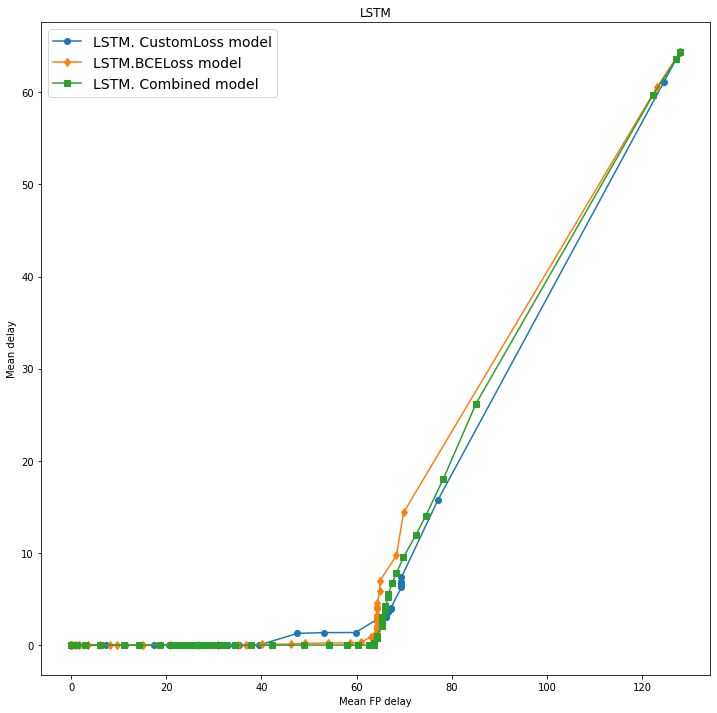

In [61]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-o', label='LSTM. CustomLoss model')
plt.plot(fp_delay_list_LSTM_bce, delay_list_LSTM_bce, '-d', label='LSTM.BCELoss model')
plt.plot(fp_delay_list_LSTM_combined, delay_list_LSTM_combined, '-s', label='LSTM. Combined model')

plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
plt.title('LSTM')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);

### Evaluate GRU

In [62]:
#model_GRU_bce = torch.load("experiments2/model_GRU_bce.pth")
#model_GRU_custom = torch.load("experiments2/model_GRU_custom.pth")
#model_GRU_combined = torch.load("experiments2/model_GRU_combined.pth")

In [63]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_GRU_bce, fn_number_list_GRU_bce, 
 delay_list_GRU_bce, fp_delay_list_GRU_bce) = get_pareto_metrics_for_threshold(model_GRU_bce, final_test_loader, 
                                                                                 threshold_list, RNN_flag=True)

In [64]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_GRU_custom, fn_number_list_GRU_custom, 
 delay_list_GRU_custom, fp_delay_list_GRU_custom) = get_pareto_metrics_for_threshold(model_GRU_custom, final_test_loader, 
                                                                                       threshold_list, RNN_flag=True)

In [65]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_GRU_combined, fn_number_list_GRU_combined, delay_list_GRU_combined, fp_delay_list_GRU_combined) = get_pareto_metrics_for_threshold(model_GRU_combined, final_test_loader, threshold_list, RNN_flag=True)

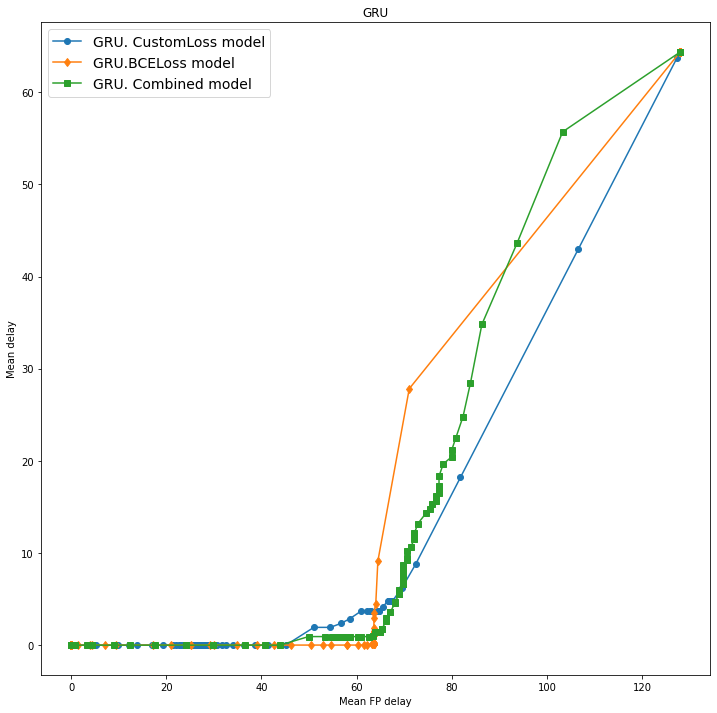

In [66]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_GRU_custom, delay_list_GRU_custom, '-o', label='GRU. CustomLoss model')
plt.plot(fp_delay_list_GRU_bce, delay_list_GRU_bce, '-d', label='GRU.BCELoss model')
plt.plot(fp_delay_list_GRU_combined, delay_list_GRU_combined, '-s', label='GRU. Combined model')

plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
plt.title('GRU')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);

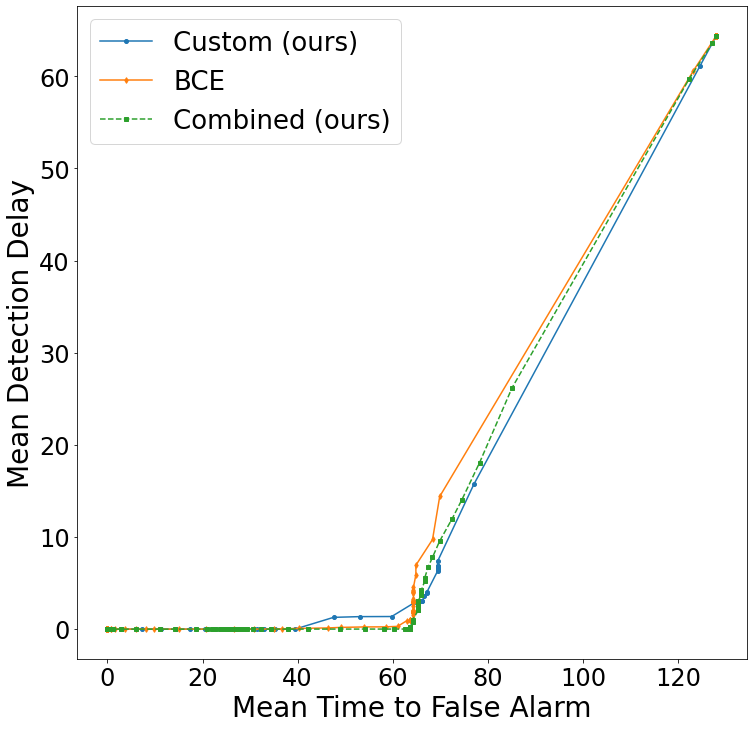

In [67]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-o', markersize=4, label='Custom (ours)')
plt.plot(fp_delay_list_LSTM_bce, delay_list_LSTM_bce, '-d', markersize=4, label='BCE')
plt.plot(fp_delay_list_LSTM_combined, delay_list_LSTM_combined, '--s', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);
plt.savefig('normal100d_LSTM.pdf', bbox_inches='tight')

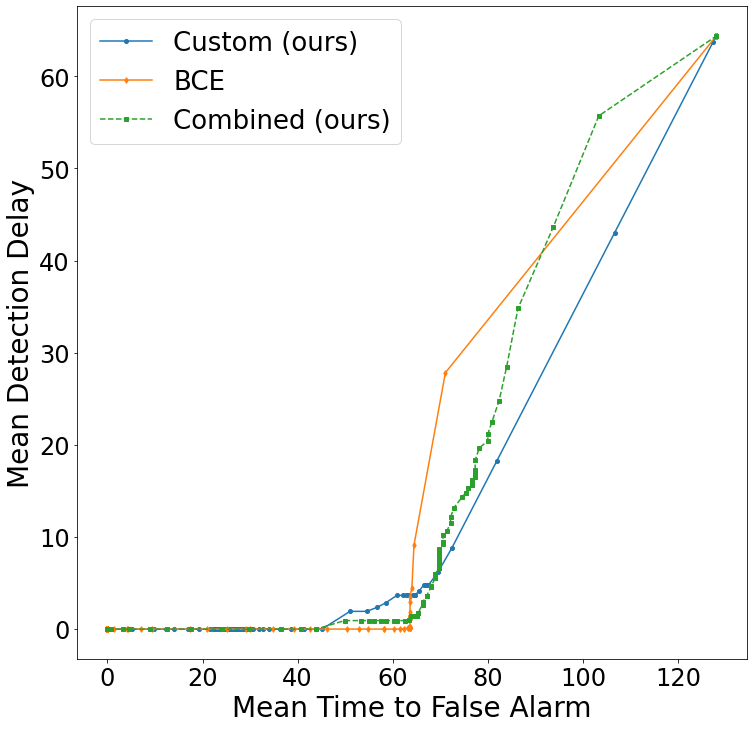

In [68]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_GRU_custom, delay_list_GRU_custom, '-o', markersize=4, label='Custom (ours)')
plt.plot(fp_delay_list_GRU_bce, delay_list_GRU_bce, '-d', markersize=4, label='BCE')
plt.plot(fp_delay_list_GRU_combined, delay_list_GRU_combined, '--s', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);
plt.savefig('normal100d_GRU.pdf', bbox_inches='tight')

In [79]:
%load_ext autoreload
%autoreload 1
%aimport metrics_v4
import metrics_v4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
metrics_v4.save_metrics_to_file_new_version('GRU_custom', 
                                 model_GRU_custom, 
                                 final_test_loader, 
                                 batch_size=4,
                                 seq_len=128,
                                 fp_delay = fp_delay_list_GRU_custom,
                                 threshold_list=threshold_list,
                                 x_coord_arr = [40, 45, 50, 55, 60, 65, 70, 75, 80],
                                 lstm_flag=False,
                                 rnn_flag=True,
                                 path_to_save='experiments5/'
                                 )

38.54 0.5562929886676822 41.27 0.5931214442021029 40
TP: 10 TN: 0 FP: 90 FN: 0 DELAY: 0.0 FP_DELAY 39.52
41.27 0.5931214442021029 45.15 0.6289320892498149 45
TP: 14 TN: 0 FP: 86 FN: 0 DELAY: 0.0 FP_DELAY 44.32
45.15 0.6289320892498149 51.01 0.6633797050476777 50
TP: 35 TN: 0 FP: 63 FN: 2 DELAY: 1.37 FP_DELAY 49.9
54.49 0.6961742683443586 56.74 0.7270882739906794 55
TP: 45 TN: 0 FP: 52 FN: 3 DELAY: 1.93 FP_DELAY 54.93
58.61 0.7559594369323567 60.84 0.7826891897526391 60
TP: 59 TN: 0 FP: 35 FN: 6 DELAY: 3.66 FP_DELAY 60.32
64.62 0.8844411322964855 64.62 0.8989788537276263 65
TP: 0 TN: 0 FP: 0 FN: 100 DELAY: 64.36 FP_DELAY 128.0
69.51 0.9623558248267451 72.41 0.9674523120684658 70
TP: 89 TN: 0 FP: 1 FN: 10 DELAY: 6.19 FP_DELAY 69.51
72.41 0.9674523120684658 81.83 0.9718789695244026 75
TP: 84 TN: 0 FP: 0 FN: 16 DELAY: 10.59 FP_DELAY 74.22
72.41 0.9674523120684658 81.83 0.9718789695244026 80
TP: 79 TN: 0 FP: 0 FN: 21 DELAY: 14.47 FP_DELAY 78.1


In [ ]:
metrics_v4.save_metrics_to_file_new_version('GRU_custom', 
                                 model_GRU_custom, 
                                 final_test_loader, 
                                 batch_size=4,
                                 seq_len=128,
                                 fp_delay = fp_delay_list_GRU_custom,
                                 threshold_list=threshold_list,
                                 x_coord_arr = [40, 45, 50, 55, 60, 65, 70, 75, 80],
                                 lstm_flag=False,
                                 rnn_flag=True,
                                 path_to_save='experiments5/'
                                 )

In [83]:
print('LSTM_custom: ', metrics_v4.area_under_graph(delay_list_LSTM_custom, fp_delay_list_LSTM_custom))
print('LSTM_bce: ', metrics_v4.area_under_graph(delay_list_LSTM_bce, fp_delay_list_LSTM_bce))
print('LSTM_combined: ', metrics_v4.area_under_graph(delay_list_LSTM_combined, fp_delay_list_LSTM_combined)) 

print('\n')

print('GRU_custom: ', metrics_v4.area_under_graph(delay_list_GRU_custom, fp_delay_list_GRU_custom))
print('GRU_bce: ', metrics_v4.area_under_graph(delay_list_GRU_bce, fp_delay_list_GRU_bce))
print('GRU_combined: ', metrics_v4.area_under_graph(delay_list_GRU_combined, fp_delay_list_GRU_combined))  

LSTM_custom:  2179.1043
LSTM_bce:  2355.8684000000003
LSTM_combined:  2248.5923500000004


GRU_custom:  2121.79745
GRU_bce:  2750.9117
GRU_combined:  2607.5621
